In [1]:
from utils import *

### 1. Creation and Vizualization of Impulse Responses and Effect Deterioration / Addiction

First let us look at a very simple linear models that aims to capture the effects of an abstract stimulant over time. The A process would correspond to released (& bonded) dopamine, while the B process would correspond to slow increases in the dopamine receptors (leading to increased reuptake). A timestep is one day. We create four systems below, capturing a diverse set of dose responses.

In [2]:
drug = {}

In [3]:
drug['A'] = OP(lin_sys=(np.array([[0.900, 0], [0, 0.95]]), np.array([1, 1]), np.array([2, -1]), 360))
drug['B'] = OP(lin_sys=(np.array([[0.800, 0], [0, 0.90]]), np.array([1, 1]), np.array([3, -1.5]), 240))
drug['C'] = OP(lin_sys=(np.array([[0.010, 0], [0, 0.95]]), np.array([1, 1]), np.array([3, -0.1]), 180))
drug['D'] = OP(lin_sys=(np.array([[0.001, 0], [0, 0.75]]), np.array([1, 1]), np.array([6, -2]), 180))

In order to study the different protocols, we first need to start off in an 'addicted' state of the system. We vizualize this below, where we assume addiction happened due to taking 1 unit of dose every day for 30 days. We also add the effects of interrupted dosing.

In [4]:
addict_T = 60
addict_dose = 1

addict_dose_history = list(addict_dose * np.ones(addict_T))

addict_dose_history_interrupted = list(addict_dose * np.ones(addict_T))
for i in [3, 4, 5]:
    addict_dose_history_interrupted[i::6] = np.zeros(addict_T//6)

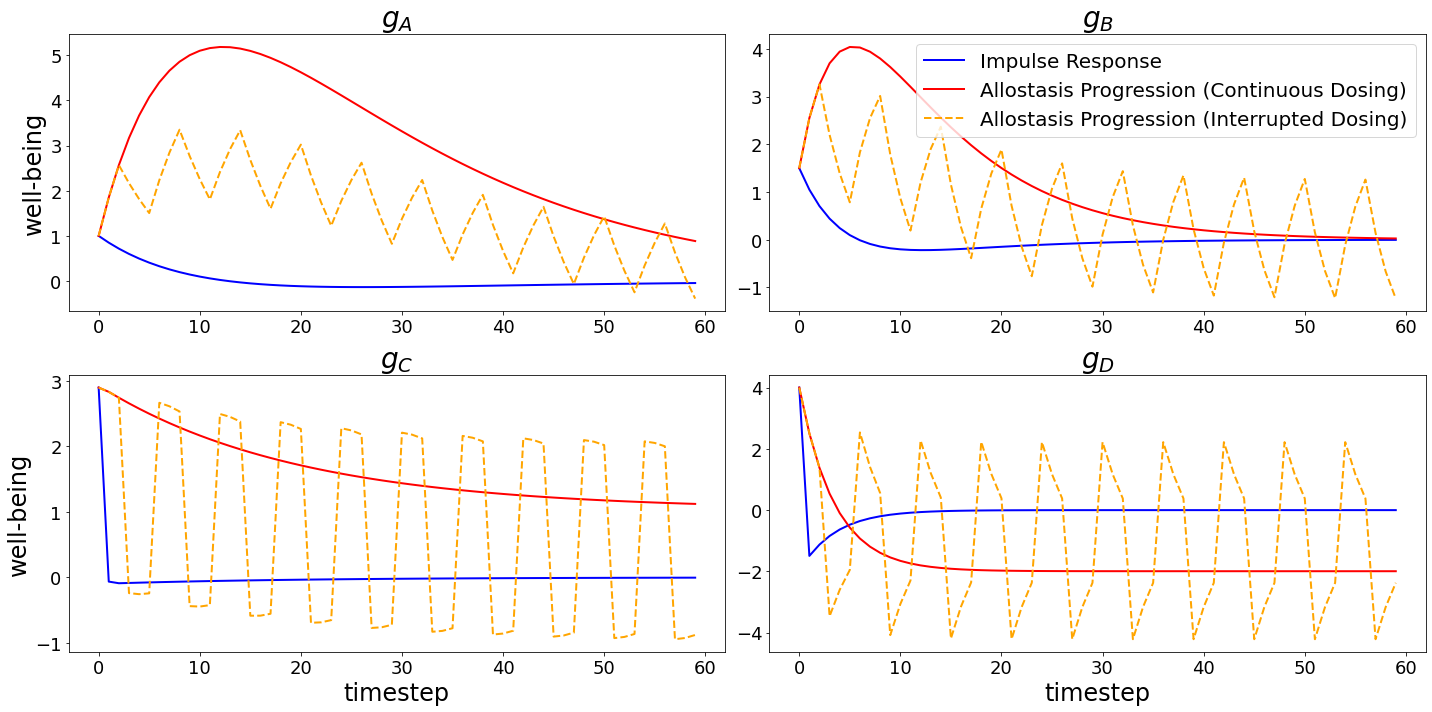

In [5]:
plot_responses(drug, addict_T, addict_dose_history, addict_dose_history_interrupted)
plt.savefig("drug_responses.pdf")

## 2. Extract Population Metrics For The Protocols

We consider the situation where all units have the same underlying dose response, and experience some uniform noise on each measurement and each unit has a desired obs_min drawn uniformly from a drug-adjusted range of observations.

In [6]:
# Task definition
trials = 100
noise_lb, noise_ub = (-0.25, 0.25)

obs_min_lb, obs_min_ub = {}, {}
obs_min_lb['A'], obs_min_ub['A'] = -1.5, 0.5
obs_min_lb['B'], obs_min_ub['B'] = -2, 0
obs_min_lb['C'], obs_min_ub['C'] = -1, 1
obs_min_lb['D'], obs_min_ub['D'] = -4.25, -2.25

taper_T = {}
taper_T['A'], taper_T['B'], taper_T['C'], taper_T['D'] = 180, 120, 90, 15

In [7]:
# Dictionaries for metrics of interest

viol_avg, dose_avg, success_avg = {}, {}, {}
for drug_idx in drug.keys():
    viol_avg[drug_idx], dose_avg[drug_idx], success_avg[drug_idx] = {}, {}, {}

Now let's run it on our protocols!

In [8]:
# 1. Cold Turkey

for drug_idx in drug.keys():
    viol_avg[drug_idx]['ct'], dose_avg[drug_idx]['ct'], success_avg[drug_idx]['ct'] = test_pop(trials, \
                                                            system=(drug[drug_idx], addict_dose_history), \
                                                            noise_generator=uniform(noise_lb, noise_ub), \
                                                            obs_min_generator=uniform(obs_min_lb[drug_idx], \
                                                                                      obs_min_ub[drug_idx]),
                                                            protocol=cold_turkey, \
                                                            taper_T=taper_T[drug_idx])

In [9]:
# 2. Linear

lin_rates = {}
lin_rates['A'] = [0.001, 0.002, 0.003, 0.004]
lin_rates['B'] = [0.0025, 0.005, 0.0075, 0.01]
lin_rates['C'] = [0.0025, 0.005, 0.0075, 0.01, 0.0125]
lin_rates['D'] = [0.01, 0.02, 0.04, 0.05, 0.06, 0.07, 0.08]

for drug_idx in drug.keys():
    for lin_rate in lin_rates[drug_idx]:
        viol_avg[drug_idx]['lin-'+str(lin_rate)], dose_avg[drug_idx]['lin-'+str(lin_rate)], \
        success_avg[drug_idx]['lin-'+str(lin_rate)] = test_pop(trials, \
                                                            system=(drug[drug_idx], addict_dose_history), \
                                                            noise_generator=uniform(noise_lb, noise_ub), \
                                                            obs_min_generator=uniform(obs_min_lb[drug_idx], \
                                                                                      obs_min_ub[drug_idx]), \
                                                            protocol=linear(addict_dose, lin_rate), \
                                                            taper_T=taper_T[drug_idx])

In [10]:
# 3. Exponential
exp_rates = {}

exp_rates['A'] = [0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.0]
exp_rates['B'] = [0.975, 0.98, 0.985, 0.99, 0.995, 0.999]
exp_rates['C'] = [0.975, 0.98, 0.985, 0.99, 0.995, 0.999]
exp_rates['D'] = [0.93, 0.95, 0.97, 0.99]

for drug_idx in drug.keys():
    for exp_rate in exp_rates[drug_idx]:
        viol_avg[drug_idx]['exp-'+str(exp_rate)], dose_avg[drug_idx]['exp-'+str(exp_rate)], \
        success_avg[drug_idx]['exp-'+str(exp_rate)] = test_pop(trials, \
                                                            system=(drug[drug_idx], addict_dose_history), \
                                                            noise_generator=uniform(noise_lb, noise_ub), \
                                                            obs_min_generator=uniform(obs_min_lb[drug_idx], \
                                                                                      obs_min_ub[drug_idx]),
                                                            protocol=exp(addict_dose, exp_rate), \
                                                            taper_T=taper_T[drug_idx])

In [11]:
# 4. Integral

deltas = {}
deltas['A'] = [-0.8, -0.4, -0.2, 0, 0.2, 0.4]
deltas['B'] = [-0.4, -0.2, 0, 0.1, 0.2, 0.4, 0.8]
deltas['C'] = [-0.4, -0.2, 0, 0.1, 0.2, 0.4, 0.8]
deltas['D'] = [-0.1, 0, 0.1, 0.2, 0.4, 0.8]

g0_eps = 0.5

for drug_idx in drug.keys():
    g0_lb, g0_ub = drug[drug_idx].g[0] * (1 - g0_eps), drug[drug_idx].g[0] * (1 + g0_eps)

    for delta in deltas[drug_idx]:
        viol_avg[drug_idx]['I-'+str(delta)], dose_avg[drug_idx]['I-'+str(delta)], \
        success_avg[drug_idx]['I-'+str(delta)] = test_pop(trials, \
                                                            system=(drug[drug_idx], addict_dose_history), \
                                                            noise_generator=uniform(noise_lb, noise_ub), \
                                                            obs_min_generator=uniform(obs_min_lb[drug_idx], \
                                                                                      obs_min_ub[drug_idx]), \
                                                            protocol=integral(addict_dose, 0, delta, (g0_lb, g0_ub)), \
                                                            taper_T=taper_T[drug_idx])

In [12]:
# 5. MED (optimal)

for drug_idx in drug.keys():
    viol_avg[drug_idx]['MED'], dose_avg[drug_idx]['MED'], success_avg[drug_idx]['MED'] = get_MED(trials, \
                                                        system=(drug[drug_idx], addict_dose_history), \
                                                        noise_generator=uniform(noise_lb, noise_ub), \
                                                        obs_min_generator=uniform(obs_min_lb[drug_idx], \
                                                                                  obs_min_ub[drug_idx]), \
                                                        taper_T=taper_T[drug_idx])

## 3 Plotting the results

We are finally ready to plot the Figures from the paper!

### 3.a. Protocol comparison

In [13]:
exp_rates_comparison = exp_rates.copy()
exp_rates_comparison['A'] = exp_rates_comparison['A'][:-1]

lin_rates_comparison = lin_rates.copy()
lin_rates_comparison['D'] = lin_rates_comparison['D'][:-2]

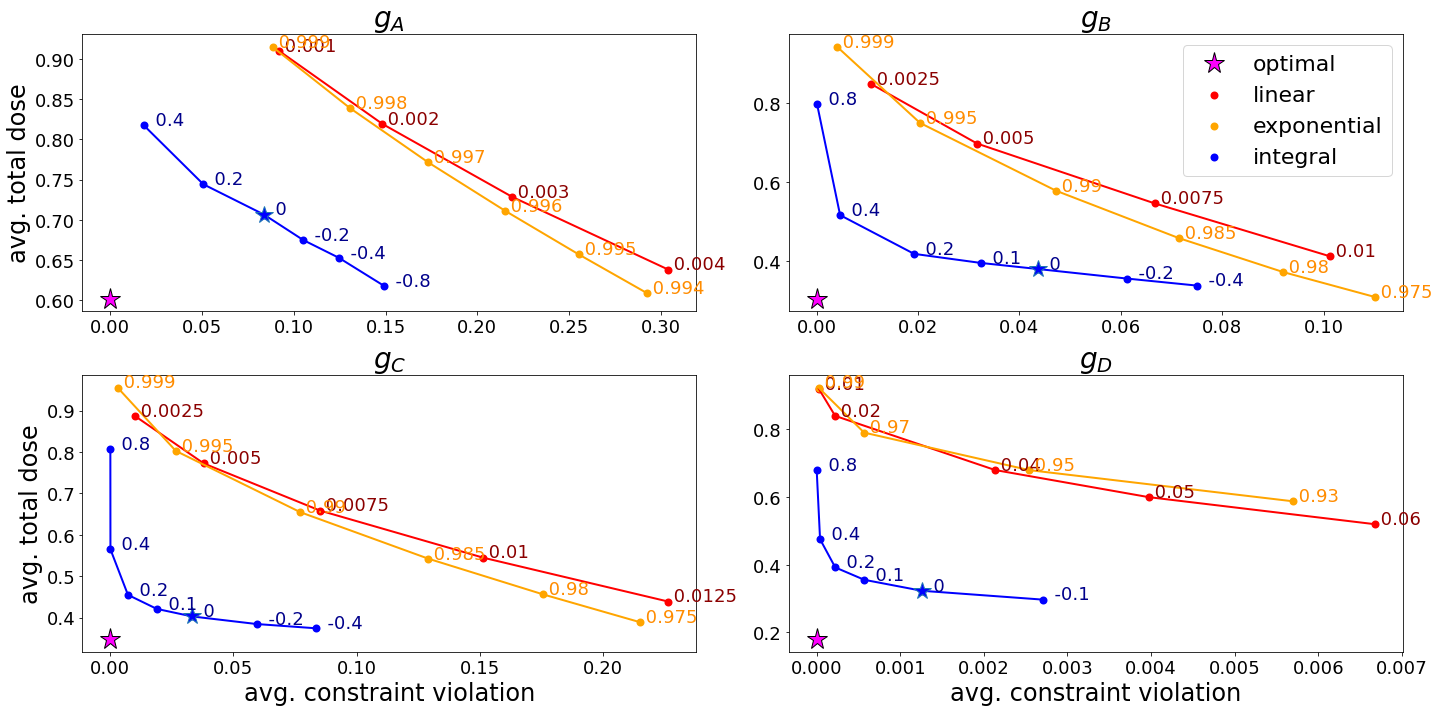

In [14]:
plot_comparison(viol_avg, dose_avg, param_sweep=(lin_rates_comparison, exp_rates_comparison, deltas))
plt.savefig("tapering_protocol_comparison.pdf");

### 3.b. Tapering Success Rate

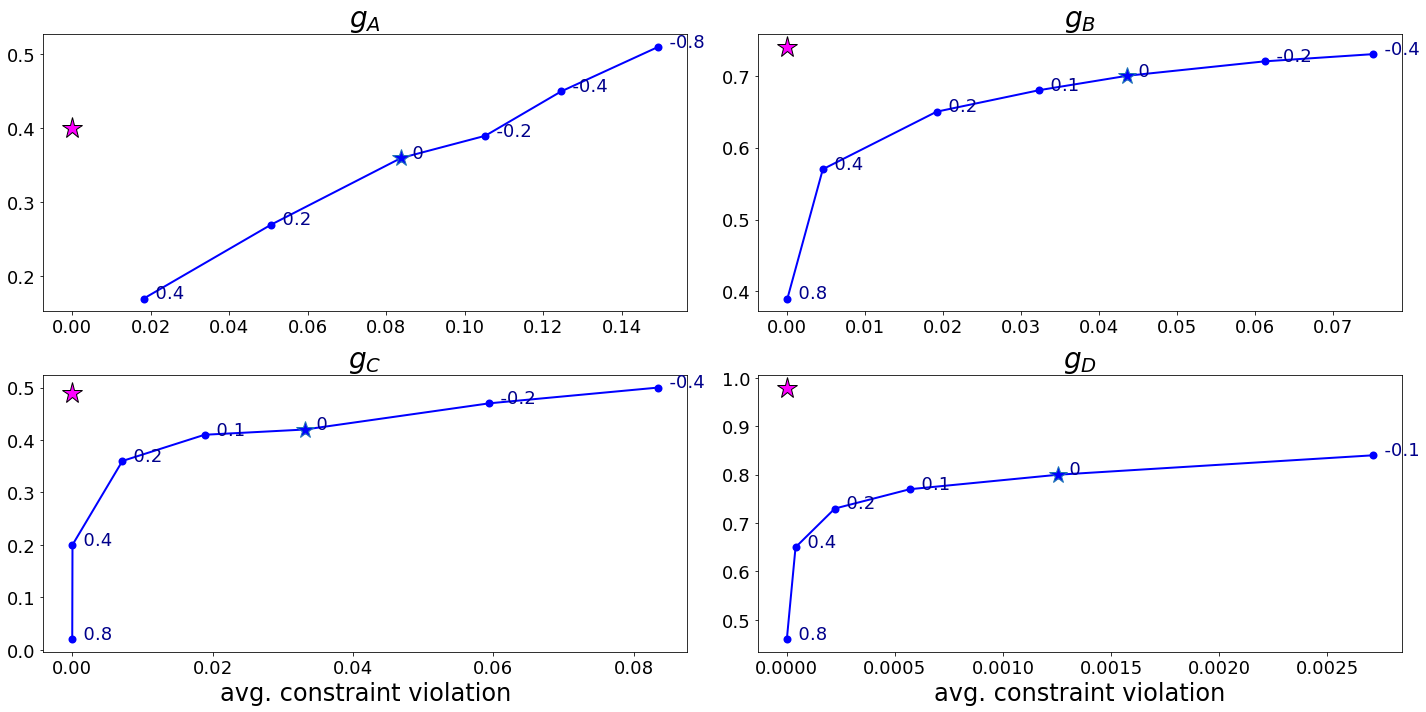

In [15]:
plot_comparison(viol_avg, success_avg, param_sweep=(None, None, deltas))
plt.savefig("tapering_success_rate.pdf");

### 3.c. Ablation over g(0) range

Varying over four ranges, and all the prior deltas.

In [16]:
g0_ranges = [(0.0, 0.0), (0.5, 0.5), (0.5, 2), (0.65, 0.5)] 

for drug_idx in drug.keys():
    for g0_range in g0_ranges:
        g0_eps_lb, g0_eps_ub = g0_range
        g0_lb, g0_ub = drug[drug_idx].g[0] * (1 - g0_eps_lb), drug[drug_idx].g[0] * (1 + g0_eps_ub)
    
        for delta in deltas[drug_idx]:
            viol_avg[drug_idx]['I-'+str(g0_range)+'-'+str(delta)], \
            dose_avg[drug_idx]['I-'+str(g0_range)+'-'+str(delta)], \
            success_avg[drug_idx]['I-'+str(g0_range)+'-'+str(delta)] = test_pop(trials, \
                                                                system=(drug[drug_idx], addict_dose_history), \
                                                                noise_generator=uniform(noise_lb, noise_ub), \
                                                                obs_min_generator=uniform(obs_min_lb[drug_idx], \
                                                                                          obs_min_ub[drug_idx]), \
                                                                protocol=integral(addict_dose, 0, delta, (g0_lb, g0_ub)), \
                                                                taper_T=taper_T[drug_idx])

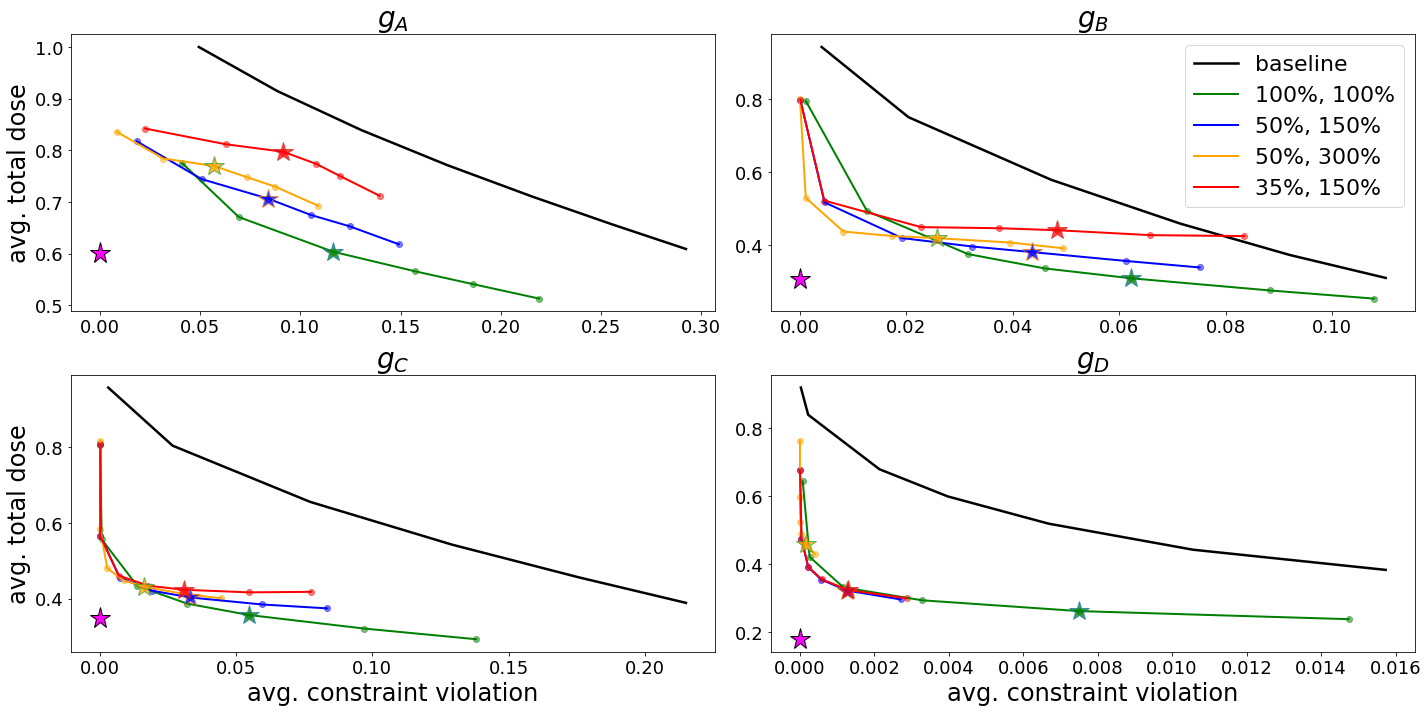

In [17]:
plot_ablation(viol_avg, dose_avg, param_sweep=(lin_rates, exp_rates, deltas, g0_ranges))
plt.savefig("g(0)_ablation.pdf");

Varying over more ranges, taking $\delta=0$.

In [18]:
g0_ranges_ext = [(0.0, 0.0), (0.0, 1.0), (0.25, 0.25), (0.5, 0.5), (0.5, 2.0), (0.5, 3.0), \
                 (0.65, 0.0), (0.65, 0.5), (0.65, 2.), (0.75, 0.0), (0.75, 1.0)] 

for drug_idx in drug.keys():
    for g0_range in g0_ranges_ext:
        g0_eps_lb, g0_eps_ub = g0_range
        g0_lb, g0_ub = drug[drug_idx].g[0] * (1 - g0_eps_lb), drug[drug_idx].g[0] * (1 + g0_eps_ub)

        viol_avg[drug_idx]['I-'+str(g0_range)], dose_avg[drug_idx]['I-'+str(g0_range)], _ = test_pop(trials, \
                                                            system=(drug[drug_idx], addict_dose_history), \
                                                            noise_generator=uniform(noise_lb, noise_ub), \
                                                            obs_min_generator=uniform(obs_min_lb[drug_idx], \
                                                                                      obs_min_ub[drug_idx]), \
                                                            protocol=integral(addict_dose, 0, 0, (g0_lb, g0_ub)), \
                                                            taper_T=taper_T[drug_idx])

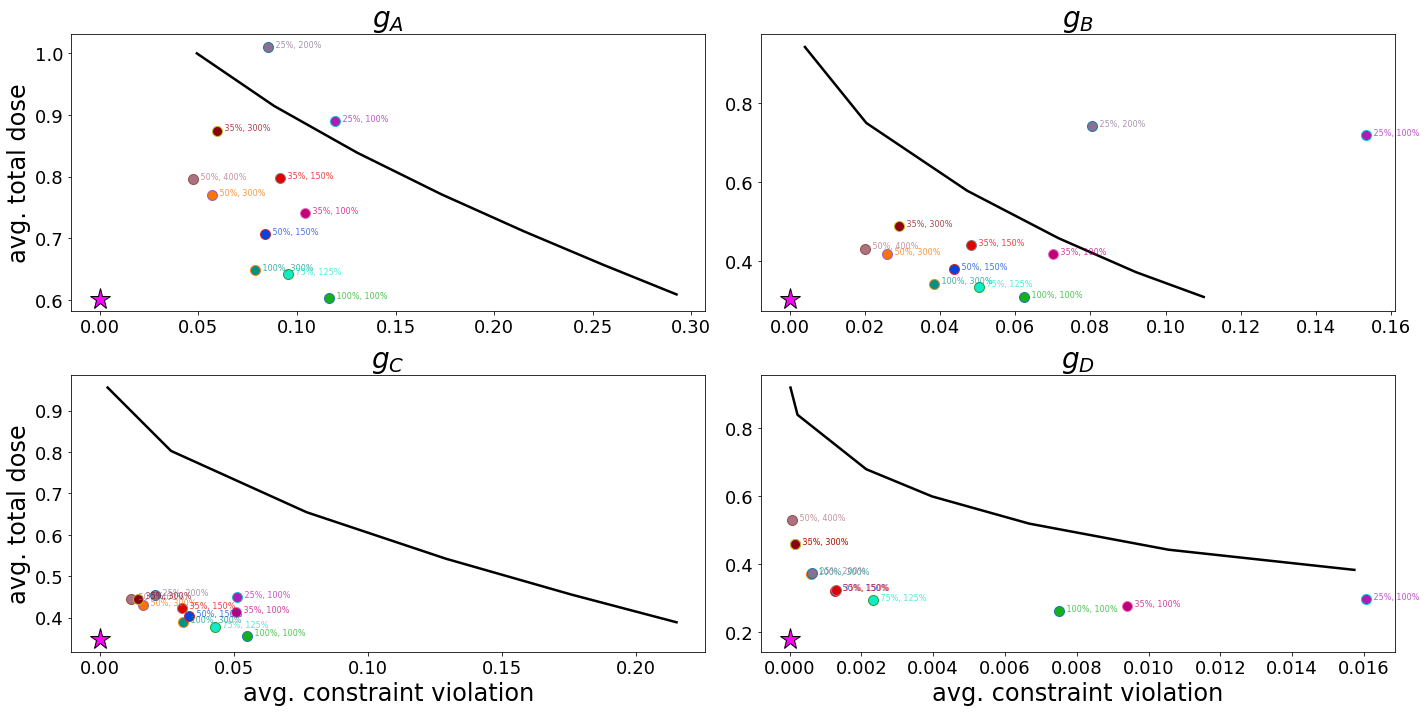

In [19]:
plot_ablation_ext(viol_avg, dose_avg, param_sweep=(lin_rates, exp_rates, g0_ranges_ext))
plt.savefig("g(0)_ablation_ext.pdf");